Data: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [1]:
import torch
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

device = "cuda:0"
seed_everything(42)

In [2]:
class HouseDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, statistics) -> None:
        super().__init__()
        self.dataframe = dataframe
        self.statistics = statistics

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        area = (row.LotArea - self.statistics['LotArea'][0]) / self.statistics['LotArea'][1]
        year = (row.YearBuilt - self.statistics['YearBuilt'][0]) / self.statistics['YearBuilt'][1]
        price = row.SalePrice
        return torch.Tensor([area, year]), torch.Tensor([price])


dataframe = pd.read_csv('/home/sestek/workspace/medium/cpp_series/data/house/train.csv')
dataframe = dataframe.sample(frac=1).reset_index(drop=True)
dataframe.dropna()

limit = int(len(dataframe) * 0.8)
train_df = dataframe[:limit].loc[:, ['LotArea', 'YearBuilt', 'SalePrice']].reset_index(drop=True)
test_df = dataframe[limit:].loc[:, ['LotArea', 'YearBuilt', 'SalePrice']].reset_index(drop=True)

statistics = {
    'LotArea': [train_df.LotArea.mean(), train_df.LotArea.std()],
    'YearBuilt': [train_df.YearBuilt.mean(), train_df.YearBuilt.std()],
}
train_dataset, test_dataset = HouseDataset(train_df, statistics), HouseDataset(test_df, statistics)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=128)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=128)

In [3]:
statistics

{'LotArea': [10597.72089041096, 10684.958322516175],
 'YearBuilt': [1971.1207191780823, 30.27955974415448]}

In [4]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = torch.nn.Linear(2, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.fc3 = torch.nn.Linear(100, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        return x


model = MLP().to(device)

In [5]:
dataloaders = {'train': train_dl, 'val': test_dl}
dataset_sizes = {'train':len(train_dataset), 'val':len(test_dataset)}
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.L1Loss()

loss_dict = {
    'train': [],
    'val': [],
}

pbar = tqdm(range(100))
for epoch in pbar:

    train_loss, val_loss = [], []
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / dataset_sizes[phase]
        if phase == 'train':
            train_loss.append(epoch_loss)
        else:
            val_loss.append(epoch_loss)
    
    epoch_train_loss = torch.mean(torch.Tensor(train_loss))
    epoch_val_loss = torch.mean(torch.Tensor(val_loss))

    pbar.desc = f"train loss {epoch_train_loss:.2f} val loss {epoch_val_loss:.2f}"
    loss_dict['train'].append(epoch_train_loss)
    loss_dict['val'].append(epoch_val_loss)

train loss 39283.43 val loss 36274.70: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s] 


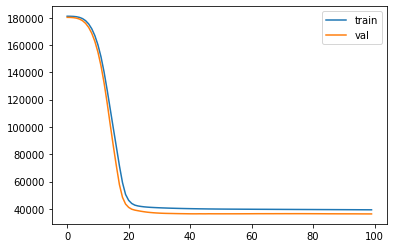

In [6]:
plt.plot(loss_dict['train'], label='train')
plt.plot(loss_dict['val'], label='val')
plt.legend()
plt.show()

In [7]:
for inputs, labels in test_dl:
    inputs = inputs.to(device)
    labels = labels.to(device)

    preds = model(inputs)

    #for i in range(preds.shape[0]):
    #    print(f"{preds[i].item():.2f} - {labels[i].item():.2f}")
    break

In [8]:
# Export Torchscript model
traced_script_module = torch.jit.trace(model.cpu(), torch.tensor([-0.1741, -1.5892]))
traced_script_module.save("traced_house_price_prediction.pt")

In [9]:
inputs[0], labels[0]

(tensor([-0.1741, -1.5892], device='cuda:0'),
 tensor([210000.], device='cuda:0'))

In [10]:
dataframe[['LotArea', 'YearBuilt', 'SalePrice']]

,LotArea,YearBuilt,SalePrice
0,8414,1963,154500
1,12256,1994,325000
2,8960,1927,115000
3,5000,1947,159000
4,12898,2007,315500
...,...,...,...
1455,9317,2006,176432
1456,7804,1928,135000
1457,8172,1955,115000
1458,7642,1918,189950
